# MODEL ANALYSIS - DATA MINING (TO UPDATE DOC)

## Goal
- From the generated *.csv* file with **model_analysis_generator** notebook, a data analysis is performed.

## Concepts
- **Interfold stability**: standard deviation (std) of the predictions of the model folds where the lesion is part of the **training set** (in our case, 4 models out of 5).
- **Translation stability**: standard deviation (std) of the predictions of the translated versions of the lesion in the model fold where the lesion is part of the **testing set**. Can be performed for different translation distances (1,2,3,4,5...)

In [18]:

import numpy as np
import sys
sys.path.append("..")
from config import *
import time
import os
from tqdm import tqdm
import nibabel as nib
import scipy.ndimage as snd
from widgets import *
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from widgets import ContrastsViewer3D

In [19]:

CSV_FILEPATH = "binet_phase_flair-all.csv"
WHERE_TO_SAVE = os.path.join(MODELS_FIGS_SAVE_TO, "errors_analysis")
if not os.path.exists(WHERE_TO_SAVE):
    os.mkdir(WHERE_TO_SAVE)

## 1. Loading and processing the data

In [20]:

votes_df = pd.read_excel("/media/german/Elements/RimProject/excels/votes_preconsensus.xlsx", sheet_name='Lesion results')[["Patient", "Lesion_ID", "Martina", "Pietro"]]
votes_df["lesion"] = votes_df["Lesion_ID"]
votes_df["patient"] = votes_df["Patient"]
votes_df = votes_df[["patient", "lesion", "Martina", "Pietro"]]
patients = list(votes_df["patient"])

# we fix the csv
counter = 0
last = 0
for i in range(len(patients)):
    if np.isnan(patients[i]):
        patients[i] = last
    else:
        last = patients[i]
votes_df["patient"] = np.array(patients, dtype=int)
votes_df = votes_df.fillna(0)

path = os.path.join(MODELS_LOAD_FROM, str(CSV_FILEPATH))
df_preds = pd.read_csv(path)


votes_df = votes_df[votes_df["patient"].isin(df_preds["patient"])]

# Difficulty column: defined as difference between GT and agreement mean
#votes_df["Difficulty"] = (2 * np.abs((np.abs(votes_df["lesion"] // 1000 - 2) - votes_df[["Martina", "Pietro"]].mean(axis=1)))).astype(int)
votes_df["Difficulty"] = votes_df.apply(lambda row: 1 if row["Martina"] != row["Pietro"] else 0, axis=1)


df_preds = df_preds.join(votes_df.set_index(["patient", "lesion"]), how='left', on=["patient", "lesion"])

df_preds[["Pietro", "Martina", "Difficulty"]] = df_preds[["Pietro", "Martina", "Difficulty"]].fillna(0)
df_preds

,fold,database,patient,lesion,unseen,truth,pred,Martina,Pietro,Difficulty
0,0,0,56,2000,False,0,0.006301,0.0,0.0,0.0
1,1,0,56,2000,False,0,0.005072,0.0,0.0,0.0
2,2,0,56,2000,False,0,0.000043,0.0,0.0,0.0
3,3,0,56,2000,True,0,0.000310,0.0,0.0,0.0
4,0,0,56,2001,False,0,0.799122,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
21271,3,1,55,2018,False,0,0.005269,0.0,0.0,0.0
21272,0,1,55,2019,False,0,0.006243,0.0,0.0,0.0
21273,1,1,55,2019,False,0,0.034640,0.0,0.0,0.0
21274,2,1,55,2019,True,0,0.024685,0.0,0.0,0.0


# Patient wise Pietro/Martina agreement analysis

In [21]:
arrays_M = []
arrays_P = []
thresholds = []

for threshold in range(1, 7):
    pietro = []
    martina = []
    for (pat, grouped) in df_preds[df_preds["unseen"]].groupby("patient"):
        martina_rims = len(grouped[grouped["Martina"] == 1].index)
        pietro_rims = len(grouped[grouped["Pietro"] == 1].index)
        martina.append(martina_rims)
        pietro.append(pietro_rims)

    pietro_pw = np.array(pietro) >= threshold
    martina_pw = np.array(martina) >= threshold
    arrays_M.append(pietro_pw)
    arrays_P.append(martina_pw)
    thresholds.append(threshold)

    agreed = pietro_pw == martina_pw
    
    print(f"{threshold} or more rim+ lesions")
    print(f"> Joint probability of agreement: {np.sum(agreed) / len(pietro_pw):.4f}")
    print(f"> Kappa score: {metrics.cohen_kappa_score(pietro_pw, martina_pw):.4f}")
    print("_________________")

#print(np.sum(pietro and martina) / len(pietro))

1 or more rim+ lesions
> Joint probability of agreement: 0.8952
> Kappa score: 0.7887
_________________
2 or more rim+ lesions
> Joint probability of agreement: 0.9194
> Kappa score: 0.8287
_________________
3 or more rim+ lesions
> Joint probability of agreement: 0.9194
> Kappa score: 0.8130
_________________
4 or more rim+ lesions
> Joint probability of agreement: 0.9274
> Kappa score: 0.8043
_________________
5 or more rim+ lesions
> Joint probability of agreement: 0.9435
> Kappa score: 0.8272
_________________
6 or more rim+ lesions
> Joint probability of agreement: 0.9516
> Kappa score: 0.8281
_________________


In [22]:
from analysis import mcnemar_test

for i in range(len(arrays_M)):
    print(f"> TH={thresholds[i]}\n")
    mcnemar_test(arrays_M[i], arrays_P[i])
    print("__________________\n")

> TH=1

[[50  7]
 [ 6 61]]
statistic=6.00000, p-value=1.00000
Same proportions of errors (fail to reject H0)
__________________

> TH=2

[[72  4]
 [ 6 42]]
statistic=4.00000, p-value=0.75391
Same proportions of errors (fail to reject H0)
__________________

> TH=3

[[80  4]
 [ 6 34]]
statistic=4.00000, p-value=0.75391
Same proportions of errors (fail to reject H0)
__________________

> TH=4

[[89  4]
 [ 5 26]]
statistic=4.00000, p-value=1.00000
Same proportions of errors (fail to reject H0)
__________________

> TH=5

[[95  4]
 [ 3 22]]
statistic=3.00000, p-value=1.00000
Same proportions of errors (fail to reject H0)
__________________

> TH=6

[[100   2]
 [  4  18]]
statistic=2.00000, p-value=0.68750
Same proportions of errors (fail to reject H0)
__________________



In [23]:
df_preds

,fold,database,patient,lesion,unseen,truth,pred,Martina,Pietro,Difficulty
0,0,0,56,2000,False,0,0.006301,0.0,0.0,0.0
1,1,0,56,2000,False,0,0.005072,0.0,0.0,0.0
2,2,0,56,2000,False,0,0.000043,0.0,0.0,0.0
3,3,0,56,2000,True,0,0.000310,0.0,0.0,0.0
4,0,0,56,2001,False,0,0.799122,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
21271,3,1,55,2018,False,0,0.005269,0.0,0.0,0.0
21272,0,1,55,2019,False,0,0.006243,0.0,0.0,0.0
21273,1,1,55,2019,False,0,0.034640,0.0,0.0,0.0
21274,2,1,55,2019,True,0,0.024685,0.0,0.0,0.0


In [30]:

def compute(threshold_gt, threshold_experts):
    pietro = []
    martina = []
    for (pat, grouped) in df_preds[df_preds["unseen"]].groupby("patient"):
        ground_truth = len(grouped[grouped["lesion"] // 1000 == 1].index)
        if ground_truth == threshold_gt:
            martina_rims = len(grouped[grouped["Martina"] == 1].index)
            pietro_rims = len(grouped[grouped["Pietro"] == 1].index)
            martina.append(martina_rims)
            pietro.append(pietro_rims)

    print(len(pietro))
    print(pietro)
    print(martina)
    pietro_pw = np.array(pietro) >= threshold_experts
    martina_pw = np.array(martina) >= threshold_experts

    agreed = pietro_pw == martina_pw

    print(f"Patients included: exactly {threshold_gt} rim+ lesions")
    print(f"Chronic active when: {threshold_experts} or more rim+ lesions")
    print(f"> Joint probability of agreement: {np.sum(agreed) / len(pietro_pw):.4f}")
    print(f"> Kappa score: {metrics.cohen_kappa_score(pietro_pw, martina_pw):.4f}")
    print("_________________")

    
def compute_without_threshold(threshold):
    pietro = []
    martina = []
    for (pat, grouped) in df_preds[df_preds["unseen"]].groupby("patient"):
        GT = len(grouped[grouped["lesion"] // 1000 == 1].index)
        if GT == threshold:
            martina_rims = len(grouped[grouped["Martina"] == 1].index)
            pietro_rims = len(grouped[grouped["Pietro"] == 1].index)
            if martina_rims == 0 and pietro_rims == 0 and GT >= 2:
                print(pat)
            martina.append(martina_rims)
            pietro.append(pietro_rims)

    print(pietro)
    print(martina)
    pietro_pw = np.array(pietro) == threshold
    martina_pw = np.array(martina) == threshold

    agreed = pietro_pw == martina_pw

    print(f"Exactly {threshold} rim+ lesions")
    print(f"> Joint probability of agreement: {np.sum(agreed) / len(pietro_pw):.4f}")
    print(f"> Kappa score: {metrics.cohen_kappa_score(pietro_pw, martina_pw):.4f}")
    print("_________________")
    
def compute_without_threshold_biggerequal(threshold):
    pietro = []
    martina = []
    for (pat, grouped) in df_preds[df_preds["unseen"]].groupby("patient"):
        GT = len(grouped[grouped["lesion"] // 1000 == 1].index)
        if GT >= threshold:
            martina_rims = len(grouped[grouped["Martina"] == 1].index)
            pietro_rims = len(grouped[grouped["Pietro"] == 1].index)
            if martina_rims == 0 and pietro_rims == 0 and GT >= 2:
                print(pat)
            martina.append(martina_rims)
            pietro.append(pietro_rims)

    print(pietro)
    print(martina)
    pietro_pw = np.array(pietro) == threshold
    martina_pw = np.array(martina) == threshold

    agreed = pietro_pw == martina_pw

    print(f">= {threshold} rim+ lesions")
    print(f"> Joint probability of agreement: {np.sum(agreed) / len(pietro_pw):.4f}")
    print(f"> Kappa score: {metrics.cohen_kappa_score(pietro_pw, martina_pw):.4f}")
    print("_________________")


In [31]:
compute_without_threshold_biggerequal(2)

[3, 2, 2, 8, 1, 7, 30, 3, 12, 3, 4, 5, 39, 3, 11, 2, 4, 3, 7, 4, 6, 1, 1, 7, 6, 17, 28, 8, 26, 7, 7, 3, 3, 9, 5, 11, 9, 4, 2, 4, 3, 4, 2, 7, 3, 12, 7, 5, 2]
[3, 2, 4, 7, 2, 5, 27, 1, 15, 3, 2, 3, 40, 3, 9, 1, 4, 2, 1, 2, 5, 4, 2, 6, 3, 14, 23, 6, 16, 9, 14, 2, 3, 10, 6, 13, 10, 5, 1, 8, 5, 5, 3, 10, 4, 15, 14, 5, 2]
>= 2 rim+ lesions
> Joint probability of agreement: 0.7959
> Kappa score: 0.1695
_________________


In [26]:
for i in range(6):
    compute_without_threshold(i)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Exactly 0 rim+ lesions
> Joint probability of agreement: 0.9800
> Kappa score: 0.0000
_________________
[0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
[1, 1, 0, 1, 3, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Exactly 1 rim+ lesions
> Joint probability of agreement: 0.4000
> Kappa score: -0.3345
_________________
[2, 1, 3, 1, 2, 2]
[2, 2, 2, 2, 1, 2]
Exactly 2 rim+ lesions
> Joint probability of agreement: 0.3333
> Kappa score: -0.3333
_________________
[3, 3, 2, 4, 3]
[1, 3, 1, 2, 2]
Exactly 3 rim+ lesions
> Joint probability of agreement: 0.6000
> Kappa score: 0.2857
_________________
[3, 2, 3, 4, 4, 6, 2, 3]
[3, 4, 3, 2, 4, 3, 3, 4]
Exactly 

## 2. General analysis: ROC and AUC values

## 6. COMPARING RESULTS WITH PIETRO/MARTINA AGREEMENT
### DIFFICULTY
We establish a difficulty indicator per lesion:
- **Difficulty 0**: Pietro && Martina agreed on the GT label before consensus.
- **Difficulty 1**: Pietro XOR Martina did NOT agree on the GT label before consensus.
- **Difficulty 2**: Pietro && Martina did NOT agree on the GT label before consensus.

### IMPORTANT
To run this section, the file **"votes.xlsx"** is needed in the same level than this notebook. It has to contain the list with Pietro and Martina votes per lesion/patient.

### 6.1. Difficulty distribution

Interagreement rate: 61.7%


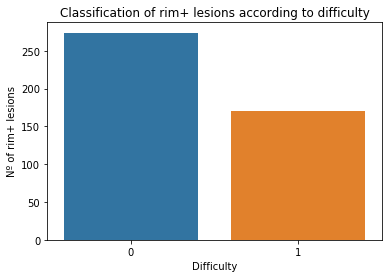

In [7]:
#sns.set(style="darkgrid")
ax = sns.countplot(votes_df.loc[votes_df["lesion"] // 1000 == 1, "Difficulty"])
ax.set_ylabel("Nº of rim+ lesions")
total_disagreement = votes_df.loc[(votes_df["lesion"] // 1000 == 1) & (votes_df["Difficulty"] == 1), "Difficulty"].count()
total_wrong_agreement = votes_df.loc[(votes_df["lesion"] // 1000 == 1) & (votes_df["Difficulty"] == 2), "Difficulty"].count()
total_rims = votes_df.loc[votes_df["lesion"] // 1000 == 1, "Difficulty"].count()

interagreement_rate = 100 - 100 * (total_disagreement + total_wrong_agreement) / total_rims
print(f"Interagreement rate: {interagreement_rate:.1f}%")
plt.title("Classification of rim+ lesions according to difficulty")
plt.savefig(os.path.join(WHERE_TO_SAVE, 'difficulty_rim_positive_classification.pdf'), dpi = 400, format='pdf', bbox_inches='tight')


Interagreement rate: 99.1%


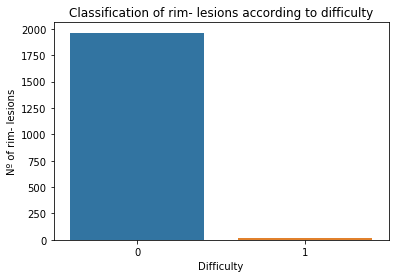

In [8]:
ax = sns.countplot(votes_df.loc[votes_df["lesion"] // 1000 == 2, "Difficulty"])
ax.set_ylabel("Nº of rim- lesions")
total_disagreement = votes_df.loc[(votes_df["lesion"] // 1000 == 2) & (votes_df["Difficulty"] == 1), "Difficulty"].count()
total_wrong_agreement = votes_df.loc[(votes_df["lesion"] // 1000 == 2) & (votes_df["Difficulty"] == 2), "Difficulty"].count()
total_rims = votes_df.loc[votes_df["lesion"] // 1000 == 2, "Difficulty"].count()

interagreement_rate = 100 - 100 * (total_disagreement + total_wrong_agreement) / total_rims
print(f"Interagreement rate: {interagreement_rate:.1f}%")
plt.title("Classification of rim- lesions according to difficulty")
plt.savefig(os.path.join(WHERE_TO_SAVE, 'difficulty_rim_negative_classification.pdf'), dpi = 400, format='pdf', bbox_inches='tight')


# KAPPA STATISTIC (CAREFUL: we need to sum the cleaned lesions)

In [9]:
cm = metrics.confusion_matrix(list(df_preds["Martina"]) + [0 for i in range(1671)], 
                              list(df_preds["Pietro"]) + [0 for i in range(1671)])
print(cm)

p0 = (cm[0,0] + cm[1,1]) / (cm.ravel().sum())

neg_M = cm[0,0] + cm[0,1]
pos_M = cm[1,0] + cm[1,1]
neg_P = cm[0,0] + cm[1,0]
pos_P = cm[0,1] + cm[1,1]
p_pos_M = pos_M / (pos_M + neg_M)
p_pos_P = pos_P / (pos_P + neg_P)
p_neg_M = 1 - p_pos_M
p_neg_P = 1 - p_pos_P

p_pos = p_pos_M * p_pos_P
p_neg = p_neg_M * p_neg_P

pe = p_pos + p_neg
k = (p0 - pe) / (1 - pe)
k

[[6525   94]
 [  94  277]]


0.7324291867445228

In [10]:
metrics.cohen_kappa_score(list(df_preds["Martina"]) + [0 for i in range(1671)], 
                              list(df_preds["Pietro"]) + [0 for i in range(1671)])

0.7324291867445225

### Comparison of the performance with Pietro and Martina in a lesion-wise level
The format of the results is:

Who <br />
(tn, fp, fn, tp) <br />
(acc, f1, fpr, fnr, tnr, tpr, ppv) <br />


In [11]:
def print_results(tn, fp, fn, tp):
    fpr = fp / (tn + fp)
    tpr = tp / (tp + fn) # recall
    tnr = tn / (tn + fp)
    fnr = fn / (fn + tp)
    FOR = fn / (fn + tn)
    
    ppv = (tp) / (tp + fp)
    f1 = (2 * ppv * tpr) / (ppv + tpr)
    acc = (tp + tn) / (tp + fn + fp + tn)
    print(np.round((acc, f1, fpr, fnr, tnr, tpr, ppv), 4))
    
who = "Pietro"
tn = df_preds.loc[(df_preds["lesion"] // 2000 == 1) & (df_preds[who] == 0.0)].count()[0]
tp = df_preds.loc[(df_preds["lesion"] // 1000 == 1) & (df_preds[who] == 1.0)].count()[0]
fp = df_preds.loc[(df_preds["lesion"] // 2000 == 1) & (df_preds[who] == 1.0)].count()[0]
fn = df_preds.loc[(df_preds["lesion"] // 1000 == 1) & (df_preds[who] == 0.0)].count()[0]
print("\n> " + who)
print((tn, fp, fn, tp))
print_results(tn, fp, fn, tp)

who = "Martina"
tn = df_preds.loc[(df_preds["lesion"] // 2000 == 1) & (df_preds[who] == 0.0)].count()[0]
tp = df_preds.loc[(df_preds["lesion"] // 1000 == 1) & (df_preds[who] == 1.0)].count()[0]
fp = df_preds.loc[(df_preds["lesion"] // 2000 == 1) & (df_preds[who] == 1.0)].count()[0]
fn = df_preds.loc[(df_preds["lesion"] // 1000 == 1) & (df_preds[who] == 0.0)].count()[0]
print("\n> " + who)
print((tn, fp, fn, tp))
print_results(tn, fp, fn, tp)


tn = df_preds.loc[(df_preds["lesion"] // 2000 == 1) & (df_preds["pred"] == 0)].count()[0]
tp = df_preds.loc[(df_preds["lesion"] // 1000 == 1) & (df_preds["pred"] == 1)].count()[0]
fp = df_preds.loc[(df_preds["lesion"] // 2000 == 1) & (df_preds["pred"] == 1)].count()[0]
fn = df_preds.loc[(df_preds["lesion"] // 1000 == 1) & (df_preds["pred"] == 0)].count()[0]
print("\n> Our algorithm")
print((tn, fp, fn, tp))
print_results(tn, fp, fn, tp)




> Pietro
(4846, 11, 102, 360)
[0.9788 0.8643 0.0023 0.2208 0.9977 0.7792 0.9704]

> Martina
(4844, 13, 104, 358)
[0.978  0.8595 0.0027 0.2251 0.9973 0.7749 0.965 ]

> Our algorithm
(4611, 246, 136, 326)
[0.9282 0.6306 0.0506 0.2944 0.9494 0.7056 0.5699]


### 6.3. Pie diagrams for confusion matrix (TN, FN, FP, TP) depending on difficulty
Ideally, algorithm should fail with difficult examples => FN and FP with high proportion of difficult examples.

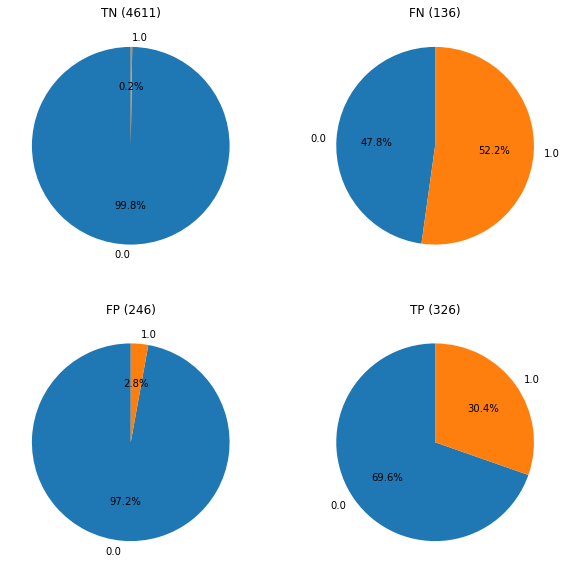

In [12]:

df_tp = df_preds.loc[(df_preds["lesion"] // 1000 == 1) & (df_preds["pred"] == 1)]
df_fn = df_preds.loc[(df_preds["lesion"] // 1000 == 1) & (df_preds["pred"] == 0)]
df_tn = df_preds.loc[(df_preds["lesion"] // 1000 == 2) & (df_preds["pred"] == 0)]
df_fp = df_preds.loc[(df_preds["lesion"] // 1000 == 2) & (df_preds["pred"] == 1)]

# Pie chart
labels = list(df_preds["Difficulty"].drop_duplicates())
sizes_TN = [df_tn.loc[df_tn["Difficulty"] == dif, "Difficulty"].count() / len(df_tn.index) for dif in labels]
sizes_FN = [df_fn.loc[df_fn["Difficulty"] == dif, "Difficulty"].count() / len(df_fn.index) for dif in labels]
sizes_FP = [df_fp.loc[df_fp["Difficulty"] == dif, "Difficulty"].count() / len(df_fp.index) for dif in labels]
sizes_TP = [df_tp.loc[df_tp["Difficulty"] == dif, "Difficulty"].count() / len(df_tp.index) for dif in labels]

#sns.set(style="darkgrid")
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].pie(sizes_TN, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax[0][0].set_title(f"TN ({len(df_tn.index)})")
ax[0][1].pie(sizes_FN, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax[0][1].set_title(f"FN ({len(df_fn.index)})")
ax[1][0].pie(sizes_FP, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax[1][0].set_title(f"FP ({len(df_fp.index)})")
ax[1][1].pie(sizes_TP, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax[1][1].set_title(f"TP ({len(df_tp.index)})")
plt.savefig(os.path.join(WHERE_TO_SAVE, 'errors_analysis_difficulty.pdf'), dpi = 400, format='pdf', bbox_inches='tight')

plt.show()

In [63]:
df_preds

,Unnamed: 0,model_name,evaluation,ensembled,fold,database,patient,lesion,unseen,truth,pred,Martina,Pietro,Difficulty
0,3,binet_phase_flair,all,False,3,0,56,2000,1,0,0,0.0,0.0,0.0
1,7,binet_phase_flair,all,False,3,0,56,2001,1,0,0,0.0,0.0,0.0
2,11,binet_phase_flair,all,False,3,0,56,2002,1,0,0,0.0,0.0,0.0
3,15,binet_phase_flair,all,False,3,0,56,2003,1,0,0,0.0,0.0,0.0
4,19,binet_phase_flair,all,False,3,0,56,2004,1,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5314,21258,binet_phase_flair,all,False,2,1,55,2014,1,0,0,0.0,0.0,0.0
5315,21262,binet_phase_flair,all,False,2,1,55,2015,1,0,0,0.0,0.0,0.0
5316,21266,binet_phase_flair,all,False,2,1,55,2016,1,0,0,0.0,0.0,0.0
5317,21270,binet_phase_flair,all,False,2,1,55,2018,1,0,0,0.0,0.0,0.0


Ttest_indResult(statistic=4.324892866060493, pvalue=2.065691853304813e-05)
Ttest_indResult(statistic=2.8703760448925104, pvalue=0.010596552512269135)


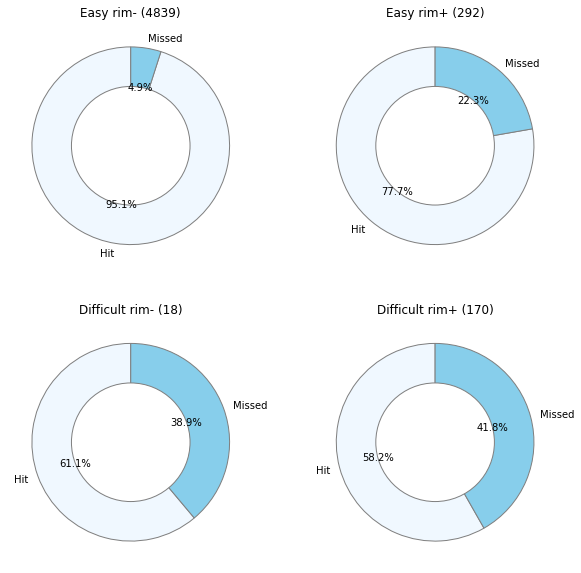

In [152]:
difficults = df_preds

difficults["Class"] = 0
difficults.loc[(difficults["lesion"] // 1000 == 1) & (difficults["pred"] == 1), "Class"] = "Hit"
difficults.loc[(difficults["lesion"] // 1000 == 1) & (difficults["pred"] == 0), "Class"] = "Missed"
difficults.loc[(difficults["lesion"] // 1000 == 2) & (difficults["pred"] == 0), "Class"] = "Hit"
difficults.loc[(difficults["lesion"] // 1000 == 2) & (difficults["pred"] == 1), "Class"] = "Missed"

difficults["Type"] = 0
difficults.loc[(difficults["lesion"] // 1000 == 1), "Type"] = "Rim+"
difficults.loc[(difficults["lesion"] // 1000 == 2), "Type"] = "Rim-"

easy_rim_pos = difficults.loc[(difficults["Type"] == "Rim+") & (df_preds["Difficulty"] == 0)]
easy_rim_neg = difficults.loc[(difficults["Type"] == "Rim-") & (df_preds["Difficulty"] == 0)]
hard_rim_pos = difficults.loc[(difficults["Type"] == "Rim+") & (df_preds["Difficulty"] == 1)]
hard_rim_neg = difficults.loc[(difficults["Type"] == "Rim-") & (df_preds["Difficulty"] == 1)]

labels = sorted(difficults["Class"].drop_duplicates())
rim_pos_0 = [easy_rim_pos.loc[easy_rim_pos["Class"] == dif, "Type"].count() / len(easy_rim_pos.index) for dif in labels]
rim_neg_0 = [easy_rim_neg.loc[easy_rim_neg["Class"] == dif, "Type"].count() / len(easy_rim_neg.index) for dif in labels]

labels = sorted(difficults["Class"].drop_duplicates())
rim_pos_1 = [hard_rim_pos.loc[hard_rim_pos["Class"] == dif, "Type"].count() / len(hard_rim_pos.index) for dif in labels]
rim_neg_1 = [hard_rim_neg.loc[hard_rim_neg["Class"] == dif, "Type"].count() / len(hard_rim_neg.index) for dif in labels]

import scipy
print(scipy.stats.ttest_ind(easy_rim_pos["Class"] == "Hit",
                           hard_rim_pos["Class"] == "Hit", equal_var=False))
print(scipy.stats.ttest_ind(easy_rim_neg["Class"] == "Hit",
                           hard_rim_neg["Class"] == "Hit", equal_var=False))
#__________________
#sns.set(style="darkgrid")
def plot_pie(title, ax, data):
    ax.pie(data, labels=labels, colors=["aliceblue", "skyblue"], autopct='%1.1f%%', shadow=False, startangle=90,
          wedgeprops = {'linewidth': 1, 'edgecolor': 'gray'})
    ax.set_title(title)
    #draw circle
    centre_circle = plt.Circle((0,0),0.6,fc='white', edgecolor='gray')
    ax.add_artist(centre_circle)
    
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_pie(f"Easy rim- ({len(easy_rim_neg.index)})", ax[0][0], rim_neg_0)
plot_pie(f"Easy rim+ ({len(easy_rim_pos.index)})", ax[0][1], rim_pos_0)
plot_pie(f"Difficult rim- ({len(hard_rim_neg.index)})", ax[1][0], rim_neg_1)
plot_pie(f"Difficult rim+ ({len(hard_rim_pos.index)})", ax[1][1], rim_pos_1)

plt.savefig(os.path.join(WHERE_TO_SAVE, 'pie_plots_difficulty.pdf'), dpi = 400, format='pdf', bbox_inches='tight')

plt.show()

/Users/german/miniconda3/envs/msrims/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/german/miniconda3/envs/msrims/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/german/miniconda3/envs/msrims/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be 

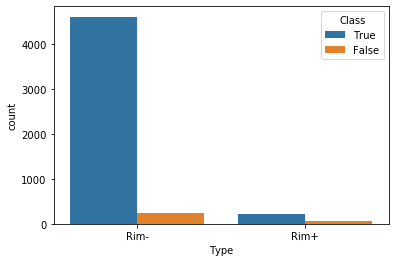

In [13]:
difficults = df_preds.loc[df_preds["Difficulty"] == 0]

difficults["Class"] = 0
difficults.loc[(difficults["lesion"] // 1000 == 1) & (difficults["pred"] == 1), "Class"] = "True"
difficults.loc[(difficults["lesion"] // 1000 == 1) & (difficults["pred"] == 0), "Class"] = "False"
difficults.loc[(difficults["lesion"] // 1000 == 2) & (difficults["pred"] == 0), "Class"] = "True"
difficults.loc[(difficults["lesion"] // 1000 == 2) & (difficults["pred"] == 1), "Class"] = "False"

difficults["Type"] = 0
difficults.loc[(difficults["lesion"] // 1000 == 1), "Type"] = "Rim+"
difficults.loc[(difficults["lesion"] // 1000 == 2), "Type"] = "Rim-"

sns.countplot(data=difficults, x="Type", hue="Class")

plt.savefig(os.path.join(WHERE_TO_SAVE, 'bar_plots_difficults.pdf'), dpi = 400, format='pdf', bbox_inches='tight')

plt.show()

### 6.4. Individual Pietro/Martina performance VS Algorithm performance [PATIENT LEVEL]
We plot the performance in terms of F1, Acc, TN, FP, FN and TP in the patient level for Pietro/Martina/Algorithm depending on the #RimLesions threshold used (ideally 2-3).

>Accuracy
Algorithm: [75.8, 85.5, 91.9, 89.5, 87.9, 89.5]
Pietro: [92.7, 94.4, 94.4, 91.9, 93.5, 94.4]
Martina: [91.9, 94.4, 92.7, 92.7, 96.0, 94.4]
>F1
Algorithm: [81.7, 83.9, 89.1, 83.5, 76.9, 77.2]
Pietro: [93.5, 92.6, 91.4, 85.3, 85.2, 85.1]
Martina: [92.9, 92.5, 88.6, 86.6, 90.9, 84.4]


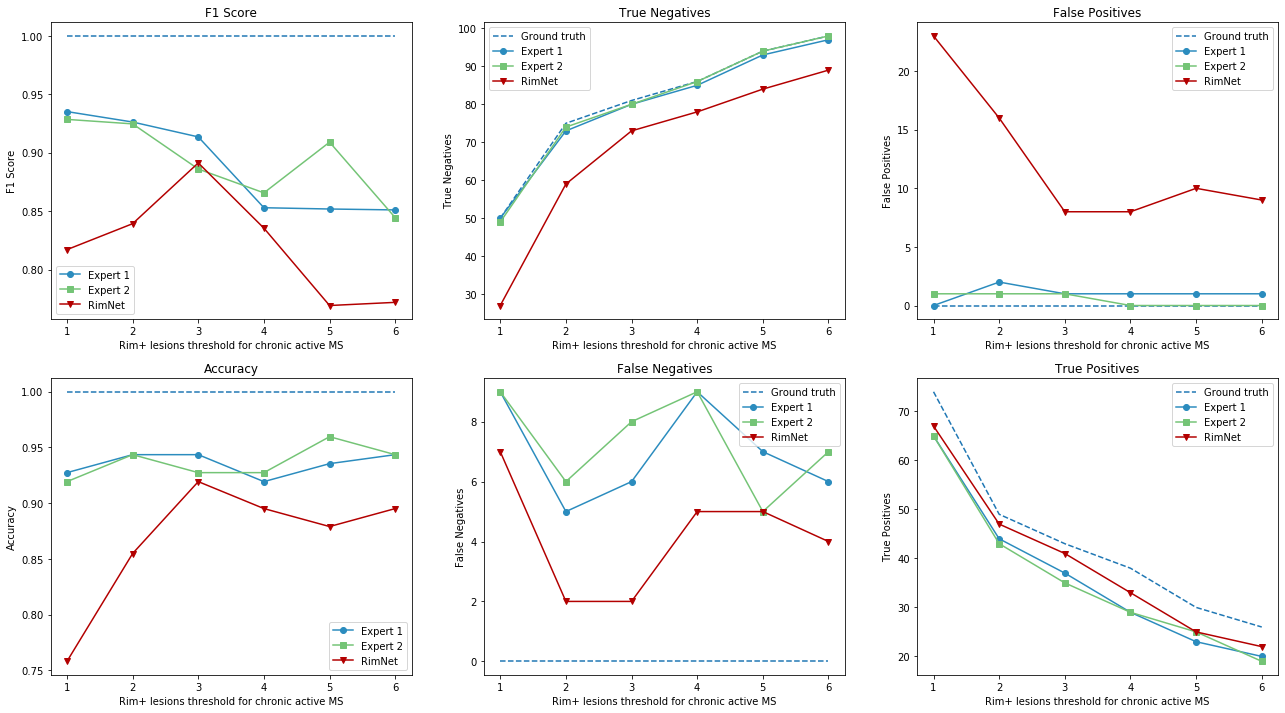

In [23]:

def get_patient_predictions():
    preds_alg = [] # number of predicted rims by algorithm
    preds_pietro = [] # number of predicted rims by Pietro
    preds_martina = [] # number of predicted rims by Martina
    truth = [] # number of real rims
    for pat, group in df_preds.groupby("patient"):
        preds_alg.append(len(group[group["pred"] == 1].index))
        preds_pietro.append(len(group[group["Pietro"] == 1].index))
        preds_martina.append(len(group[group["Martina"] == 1].index))
        truth.append(len(group[group["lesion"] // 1000 == 1].index))
    return preds_alg, preds_pietro, preds_martina, truth

def get_metrics(preds, truth, num_lesions):
    preds = [1 if p >= num_lesions else 0 for p in preds]
    truth = [1 if t >= num_lesions else 0 for t in truth]
    
    tp = int(np.array([1 if z == (1,1) else 0 for z in zip(truth, preds)]).sum())
    tn = int(np.array([1 if z == (0,0) else 0 for z in zip(truth, preds)]).sum())
    fp = int(np.array([1 if z == (0,1) else 0 for z in zip(truth, preds)]).sum())
    fn = int(np.array([1 if z == (1,0) else 0 for z in zip(truth, preds)]).sum())
    
    acc = (tp + tn) / (tn + fp + fn + tp)
    rec = (tp) / (tp + fn)
    pr = (tp) / (tp + fp)
    f1 = (2 * pr * rec) / (pr + rec)
    return (f1, acc, tn, fp, fn, tp)

def plot_values(title, gt, p, m, a, ax, show_gt=False):
    if show_gt:
        ax.plot(th_values, gt, "--", label="Ground truth")
    else:
        ax.plot(th_values, gt, "--")
    ax.plot(th_values, p, "o-", label="Expert 1", color="#2b8cbe")
    ax.plot(th_values, m, "s-", label="Expert 2", color="#74c476")
    ax.plot(th_values, a, "v-", label="RimNet", color="#b30000")
    #ax.set_ylim([0.6, 1.02])
    #ax.grid()
    ax.set_xticks(th_values)
    ax.set_xlabel("Rim+ lesions threshold for chronic active MS")
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.legend()

#sns.set_style(style="darkgrid")

preds_alg, preds_pietro, preds_martina, truth = get_patient_predictions()

th_values = list(range(1,7))
p_metrics = [get_metrics(preds_pietro, truth, th) for th in th_values]
m_metrics = [get_metrics(preds_martina, truth, th) for th in th_values]
a_metrics = [get_metrics(preds_alg, truth, th) for th in th_values]
gt_metrics = [get_metrics(truth, truth, th) for th in th_values]

p_f1, p_acc, p_tn, p_fp, p_fn, p_tp = zip(*p_metrics)
m_f1, m_acc, m_tn, m_fp, m_fn, m_tp = zip(*m_metrics)
a_f1, a_acc, a_tn, a_fp, a_fn, a_tp = zip(*a_metrics)
gt_f1, gt_acc, gt_tn, gt_fp, gt_fn, gt_tp = zip(*gt_metrics)

print(">Accuracy")
print(f"Algorithm: {[round(a*100, 1) for a in a_acc]}")
print(f"Pietro: {[round(a*100, 1) for a in p_acc]}")
print(f"Martina: {[round(a*100, 1) for a in m_acc]}")
print(">F1")
print(f"Algorithm: {[round(a*100, 1) for a in a_f1]}")
print(f"Pietro: {[round(a*100, 1) for a in p_f1]}")
print(f"Martina: {[round(a*100, 1) for a in m_f1]}")

fig, ax = plt.subplots(2, 3, figsize=(22, 12))
plot_values("F1 Score", gt_f1, p_f1, m_f1, a_f1, ax[0,0], False)
plot_values("Accuracy", gt_acc, p_acc, m_acc, a_acc, ax[1,0], False)
plot_values("True Negatives", gt_tn, p_tn, m_tn, a_tn, ax[0,1], True)
plot_values("False Positives", gt_fp, p_fp, m_fp, a_fp, ax[0,2], True)
plot_values("False Negatives", gt_fn, p_fn, m_fn, a_fn, ax[1,1], True)
plot_values("True Positives", gt_tp, p_tp, m_tp, a_tp, ax[1,2], True)
plt.savefig(os.path.join(WHERE_TO_SAVE, 'experts_comparison_v2.pdf'), dpi = 400, format='pdf', bbox_inches='tight')
plt.show()

In [15]:
print(metrics.confusion_matrix(df_preds["truth"], df_preds["Martina"]))
print(metrics.confusion_matrix(df_preds["truth"], df_preds["Pietro"]))
print(metrics.confusion_matrix(df_preds["truth"], (df_preds["pred"] == 1).astype(int)))
print(metrics.confusion_matrix(df_preds["Martina"], (df_preds["pred"] == 1).astype(int)))
print(metrics.confusion_matrix(df_preds["Pietro"], (df_preds["pred"] == 1).astype(int)))

[[4844   13]
 [ 104  358]]
[[4846   11]
 [ 102  360]]
[[4611  246]
 [ 136  326]]
[[4644  304]
 [ 103  268]]
[[4650  298]
 [  97  274]]


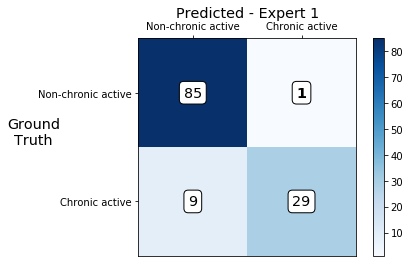

In [16]:
th = 4
who = "rimnet"
who = "pietro"
#who = "martina"


if who == "rimnet":
    data = [[a_tn[th-1], a_fp[th-1]], [a_fn[th-1], a_tp[th-1]]]
    name = "RimNet"
elif who == "pietro":
    data = [[p_tn[th-1], p_fp[th-1]], [p_fn[th-1], p_tp[th-1]]]
    name = "Expert 1"
else:
    data = [[m_tn[th-1], m_fp[th-1]], [m_fn[th-1], m_tp[th-1]]]
    name = "Expert 2"
labels = ["Non-chronic active", "Chronic active"]

fig, ax = plt.subplots()
cax = ax.matshow(data, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel(f"Predicted - {name}", fontsize='x-large')
ax.set_ylabel("Ground\nTruth", rotation=0, fontsize='x-large')
ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0', pad=0.3), fontsize='x-large', 
            fontweight='bold' if (i,j)==(0,1) else 'light')
    
plt.savefig(os.path.join(WHERE_TO_SAVE, f'PATIENT_WISE_{who}.pdf'), dpi = 400, format='pdf', bbox_inches='tight')
plt.show()

## 9. Analysis of performances of each FOLD MODEL and DIFFERENT MACHINE
Here, you can check how each model performs in ROC curve and how accurate predictions are depending on the machine used (CHUV, Basel and Brussels).

### 9.1. Analysis per fold


>>Model 0:
Threshold: 1
FPR: 0.04979253112033195
TPR: 0.7288135593220338
[1205    0  118    0]
('011', '012', '016', '017', '021', '024', '028', '030', '032', '039', '041', '050', '053', '063', '064', '065', '066', '067', '069', '075', '078', '080', '097', '099', '100', '108', '112', '114', '116', '120', '125', '131')
____________________________

>>Model 1:
Threshold: 1
FPR: 0.0516545601291364
TPR: 0.7699115044247787
[1239    0  113    0]
('001', '008', '015', '020', '022', '025', '031', '034', '035', '037', '040', '042', '043', '046', '057', '059', '060', '062', '072', '073', '081', '082', '092', '095', '098', '107', '110', '122', '124', '126', '129', '130', '132')
____________________________

>>Model 2:
Threshold: 1
FPR: 0.050778050778050775
TPR: 0.6086956521739131
[1221    0  115    0]
('003', '005', '010', '013', '014', '023', '027', '029', '044', '045', '047', '048', '052', '054', '055', '068', '077', '079', '083', '084', '093', '096', '103', '109', '113', '115', '118')
_______

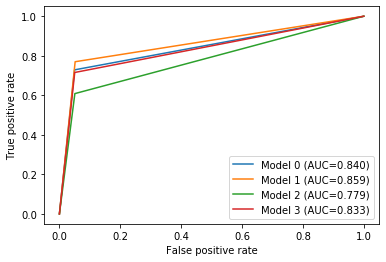

In [17]:
from utils import get_folds_structure

folds = get_folds_structure(version="all")

i = 0
for fold in folds:
    fold = list(zip(*fold))[1]
    print("\n>>Model " + str(i) + ":")
    fold_df = df_preds[df_preds["patient"].isin(fold)][["patient", "lesion", "pred"]]

    total_preds = list(fold_df["pred"])
    total_truths = list((fold_df["lesion"] // 1000 == 1).astype(int))

    fpr, tpr, thresholds = metrics.roc_curve(total_truths, total_preds)
    auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Model {i} (AUC={auc:.3f})", zorder=1)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.ylim((-0.05, 1.05))
    plt.legend()


    FPR_LESIONS = 0.05

    fpr, tpr, thresholds = metrics.roc_curve(total_truths, total_preds)

    index = np.abs(fpr - FPR_LESIONS).argmin()
    THRESHOLD_LESIONS_AUX = thresholds[index]
    print(f"Threshold: {THRESHOLD_LESIONS_AUX}")
    print(f"FPR: {fpr[index]}")
    print(f"TPR: {tpr[index]}")
    results = metrics.confusion_matrix(total_truths, [1 if p > THRESHOLD_LESIONS_AUX else 0 for p in total_preds]).ravel()
    print(results)
    i += 1
    print(fold)
    print("____________________________")

### 9.1. Analysis per center

In [18]:

for (c_id, name) in ((DATASET_BASEL_ID, "Basel"), (DATASET_CHUV_ID, "Lausanne")):
    fold_df = df_preds[df_preds["database"] == c_id][["patient", "lesion", "pred"]]

    total_preds = list(fold_df["pred"])
    total_truths = list((fold_df["lesion"] // 1000 == 1).astype(int))

    fpr, tpr, thresholds = metrics.roc_curve(total_truths, total_preds)
    index = np.abs(thresholds - THRESHOLD_LESIONS).argmin()
    auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", zorder=1)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.ylim((-0.05, 1.05))
    plt.title("ROC curve")
    plt.legend()
    
    #print(f"_____ {name} _____")
#    print(f"Threshold: {THRESHOLD_LESIONS}")
 #   print(f"FPR: {fpr[index]}")
  #  print(f"TPR: {tpr[index]}")
    results = metrics.confusion_matrix(total_truths, [1 if p > THRESHOLD_LESIONS else 0 for p in total_preds]).ravel()
   # print(results)
    i += 1
    #print("____________________________")

plt.savefig(os.path.join(WHERE_TO_SAVE, 'ROC_RESULTS_BY_CENTER.pdf'), dpi = 400, format='pdf', bbox_inches='tight')

NameError: name 'THRESHOLD_LESIONS' is not defined

In [19]:


for (c_id, name) in ((DATASET_BASEL_ID, "Basel"), (DATASET_CHUV_ID, "Lausanne")):
    fold_df = df_preds[df_preds["database"] == c_id][["patient", "lesion", "pred"]]

    total_preds = list(fold_df["pred"])
    total_truths = list((fold_df["lesion"] // 1000 == 1).astype(int))

    precision, recall, thresholds = metrics.precision_recall_curve(total_truths, total_preds)
    index = np.abs(thresholds - THRESHOLD_LESIONS).argmin()
    auc = metrics.auc(recall, precision)
    
    plt.plot(recall, precision, label=f"{name} (AUC={auc:.3f})", zorder=1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim((-0.05, 1.05))
    plt.title("PR curve")
    plt.legend()
    
    i += 1

plt.savefig(os.path.join(WHERE_TO_SAVE, 'PR_RESULTS_BY_CENTER.pdf'), dpi = 400, format='pdf', bbox_inches='tight')


NameError: name 'THRESHOLD_LESIONS' is not defined

In [153]:
df_preds

,database,patient,lesion,pred,truth,Martina,Pietro,Difficulty
0,1,11,2000,0.014782,0,0.0,0.0,0.0
1,1,11,2001,0.001912,0,0.0,0.0,0.0
2,1,11,2002,0.599275,0,0.0,0.0,0.0
3,1,11,2003,0.000037,0,0.0,0.0,0.0
4,1,11,2004,0.240674,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
5314,0,128,2190,0.000145,0,0.0,0.0,0.0
5315,0,128,2191,0.007347,0,0.0,0.0,0.0
5316,0,128,2193,0.000722,0,0.0,0.0,0.0
5317,0,128,2194,0.001386,0,0.0,0.0,0.0


In [156]:
print(df_preds["Pietro"].sum())
print(len(df_preds.index) - df_preds["Pietro"].sum())

371.0
4948.0


In [157]:
print(df_preds["Martina"].sum())
print(len(df_preds.index) - df_preds["Martina"].sum())

371.0
4948.0
